In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.table import Table

1. read the measurement PDFs from CoG and normalise. <br>
2. for different parameters theta= (a,b) of the model get the  y_m - y_PDF, for each log_NH in the data. These are Likelihood functions for each data poit for particular model, . Sum the log() <br>
* the prior for a is a gaussian centered at the LMC a value and with sigma = error on the a_LMC. b has a flat prior, we let it go within the grid limits (-2, 2).
3. log posterior = log prior(a,b) + sum log(likelihood (yi,a,b)) <br>
4. Save the log posterior for each (a,b) and lot contours


In [2]:
# metalz data
metalz = Table.read('METAL-Z_res_PF.fits')
metalz.show_in_notebook()


idx,sightline,RA [hex],Dec [hex],RA [deg],Dec [deg],log(N_SII),log(N_FeII),N(HI),d(Fe),d(S)
0,IC1613-61331,01:05:0.200,+02:09:13.10,16.2508,2.1536,15.354 .. 0.0,14.585 .. 0.0,20.84 .. 0.03,-1.12 .. 0.0,0.04 .. 0.0
1,IC1613-62024,01:05:0.6460,+02:08:49.26,16.2527,2.147,15.537 .. 0.0,14.836 .. 0.0,21.05 .. 0.03,-1.08 .. 0.0,0.02 .. 0.0
2,IC1613-64066,01:05.20700,+02:09:28.10,16.3017,2.1578,15.426 .. 0.0,14.798 .. 0.0,20.88 .. 0.04,-0.95 .. 0.0,0.08 .. 0.0
3,IC1613-67559,01:05:4.7670,+02:09:23.19,16.2699,2.1564,15.163 .. 0.0,14.61 .. 0.0,20.47 .. 0.14,-0.73 .. 0.0,0.22 .. 0.0
4,IC1613-67684,01:05:4.900,+02:09:32.60,16.2704,2.1591,14.974 .. 0.0,14.536 .. 0.0,20.44 .. 0.04,-0.77 .. 0.0,0.06 .. 0.0
5,IC1613-A13,01:05:6.25,+02:10:43.0,16.276,2.1786,15.114 .. 0.0,14.694 .. 0.0,20.26 .. 0.03,-0.44 .. 0.0,0.38 .. 0.0
6,IC1613-B11,01:04:43.8,+02:06:44.75,16.1825,2.1124,15.188 .. 0.0,14.411 .. 0.0,20.37 .. 0.05,-0.83 .. 0.0,0.35 .. 0.0
7,IC1613-B2,01:05:3.0680,+02:10:4.54,16.2628,2.1679,15.652 .. 0.0,14.988 .. 0.0,21.17 .. 0.03,-1.05 .. 0.0,0.01 .. 0.0
8,IC1613-B3,01:05:6.3700,+02:09:31.34,16.2765,2.1587,15.281 .. 0.0,14.486 .. 0.0,20.64 .. 0.06,-1.02 .. 0.0,0.17 .. 0.0
9,IC1613-B7,01:05:01.97,02:08:05.10,16.2582,2.1348,15.245 .. 0.0,14.707 .. 0.0,20.73 .. 0.03,-0.89 .. 0.0,0.04 .. 0.0


In [14]:
# slice the results table
ic1613 = metalz[:10]
sexA = metalz[10:]


In [15]:
# Fe and S abundances for IC 1613 / Sextans A to calculate depletions from logN(x)
icS, icFe = -5.53, -5.13
saFe, saS = -5.45, -5.83

z0_Fe, z0_S = 21.288, 20.84  # the z parameter for LMC (for Fe and S)


In [16]:
# (a,b) parameters grid

N = 200
A = np.linspace(-1, 1, N)
B = np.linspace(-2, 2, N)


# Functions

In [17]:
def calc_zh(NH, d_err):
    
    zH = np.sum(NH / d_err ** 2) / np.sum(1. / d_err ** 2) 
    
    print(zH)
    return(zH)

In [12]:
def log_posterior_V(x, yobs, eobs,z0,theta0,N=200): 

    from scipy.stats import norm
    """ Calculate likelihood for models  using pairs of (a,b) parameters from the grid.
        Creates a post array, mapping the posterior probabilities.
        To include the datapoint uncertanities: 
        - define the model for each data point 
        - for a data point find a location of the model on the datapoint's PDF (how far are we from the max probability)
        - 
        """
    
    ## parameter array
    A = np.linspace(-1,1, N)
    B = np.linspace(-2,2, N)

    post_array = np.zeros([N,N])  # posterior array

    # go through the coefficients grid, calculate the probability of model (a,b) by comparing with data
    
    for i in range(N):
        for j in range(N):
            theta = (A[i])  # model parameter A
            prior = log_prior(theta,theta0)  # calculate the prior probability for A
                        
            model = A[i] * (x - z0) + B[j] 
            diff = model - yobs

            likelihood = norm.logpdf(diff / eobs).sum() # sum over all data points
                
            posterior = likelihood + prior  # add the prior probability
            
            post_array[i][j] = posterior  # record the posterior probability in the posterior array

    return post_array

In [18]:
def get_pdfs(pdfs, ab, xn, M=1000):
    
    """ Read and normalize the PDFs for column density measurements from Curve of Growth """
    
    Nx = np.linspace(10,20,M)
    
    # ab reference element abundance, 
    # xn - number of data points
    
    t = Table([np.zeros(np.size(X)), np.zeros((np.size(X), M)), 
             np.zeros((np.size(X), M))], names=("NH", "PDF", "dX"))
    
    for i in range(np.size(pdfs)):
        
        p = pdfs[i]
        
        # read the Nx pdf
        
        pdf = np.loadtxt(p)
        sig = p.split("_")[0][4:]
        print(sig)
        
        a = np.where(metalz['sightline'] == sig)[0]
        nh = metalz['N(HI)'][a][0][0]
        t['NH'][i] = nh 

        # calculate depletions 
        
        Fe_d = Nx - nh - ab
        norm = pdf.T[1] / np.sum(pdf.T[1])

        t['PDF'][i] = norm
        t['dX'][i] = np.array(Fe_d, dtype='float')
        
    return t

In [19]:
def log_prior(theta, theta0):
    
    """ Define the prior for A parameter and calculate probability. 
    It is a gaussian prior centered at the a0 value and with sigma a0_err."""
    
    a = theta
    a0, a0_err = theta0
    
    pa = np.log(1.0 / (np.sqrt(2 * np.pi) * a0_err)) - 0.5 * (a-a0)**2 / a0_err**2

    return pa


In [20]:
def log_posterior(t,z0,theta0,N=200): 
    
    """ Calculate likelihood for models  using pairs of (a,b) parameters from the grid.
        Creates a post array, mapping the posterior probabilities.
        To include the datapoint uncertanities: 
        - define the model for each data point 
        - for a data point find a location of the model on the datapoint's PDF (how far are we from the max probability)
        - 
        """
    
    ## parameter array
    A = np.linspace(-1,1, N)
    B = np.linspace(-2,2, N)

    post_array = np.zeros([N,N])  # posterior array

    # go through the coefficients grid, calculate the probability of model (a,b) by comparing with data
    
    for i in range(N):
        for j in range(N):
            theta = (A[i])  # model parameter A
            prior = log_prior(theta,theta0)  # calculate the prior probability for A
            
            likelihood = 0 # define the likelhood for summing over all data points

            for k in range(np.size(t['NH'])): # go through data
                x = t['NH'][k]  # select a data point
                y = A[i] * (x - z0) + B[j]  # calculate a model at this data point
               
                d = np.absolute(t['dX'][k] - y)  # compare the modelled value to the datapoint PDF
                a = d.argmin()
                
                p = t['PDF'][k][a]  # get the probability at the model position

                likelihood += np.log(p)  # sum over all data points
                
            posterior = likelihood + prior  # add the prior probability
            
            post_array[i][j] = posterior  # record the posterior probability in the posterior array

    return post_array

In [38]:
#flat priors for a and b
def log_prior_free(theta):
    
    """ Define the prior for A parameter and calculate probability. 
    It is a gaussian prior centered at the a0 value and with sigma a0_err."""
    
    a,b = theta
    #a0, a0_err = theta0
    if -1 <= a <= 1 and -2 <= b <= 2 :
        return 0.0
    
    return -np.inf

In [39]:
def log_posterior_V_free(x, yobs, eobs,z0,N=200): 

    from scipy.stats import norm
    """ Calculate likelihood for models  using pairs of (a,b) parameters from the grid.
        Creates a post array, mapping the posterior probabilities.
        To include the datapoint uncertanities: 
        - define the model for each data point 
        - for a data point find a location of the model on the datapoint's PDF (how far are we from the max probability)
        - 
        """
    
    ## parameter array
    A = np.linspace(-1,1, N)
    B = np.linspace(-2,2, N)

    post_array = np.zeros([N,N])  # posterior array

    # go through the coefficients grid, calculate the probability of model (a,b) by comparing with data
    
    for i in range(N):
        for j in range(N):
            theta = (A[i], B[i])  # model parameter A
            prior = log_prior_free(theta)  # calculate the prior probability for A
                        
            model = A[i] * (x - z0) + B[j] 
            diff = model - yobs

            likelihood = norm.logpdf(diff / eobs).sum() # sum over all data points
                
            posterior = likelihood + prior  # add the prior probability
            
            post_array[i][j] = posterior  # record the posterior probability in the posterior array

    return post_array

# Profile Fitting results - A,B,zH fit Fe ONLY

Fitting for Fe only <br>
Bayesian fit for A and B with flat priors (across whole matrix) <br>
Calculation zH following RD2021

## IC 1613

Text(0.5, 1.0, 'IC 1613 Fe')

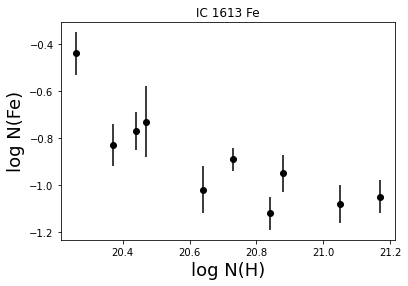

In [63]:
# data IC1613 - Fe
X = metalz['N(HI)'][:10,0]
Y = metalz['d(Fe)'][:10,0]
Yerr = metalz['d(Fe)'][:10, 1]
plt.errorbar(X,Y,yerr=Yerr, fmt='ko')
plt.xlabel("log N(H)", fontsize=18)
plt.ylabel("log N(Fe)", fontsize=18)
plt.title("IC 1613 Fe")

In [64]:
zH_ic = calc_zh(X,Yerr)
print("IC 1613 Fe zH =", f"{zH_ic:.2f}")

20.740397113889784
IC 1613 Fe zH = 20.74


Text(0.5, 1.0, 'IC1613 Fe')

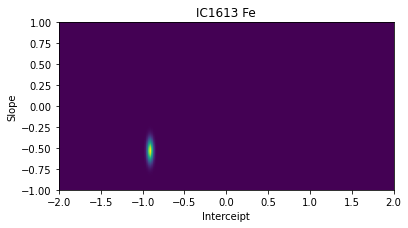

In [65]:
# A and B
post_array = log_posterior_V_free(X,Y,Yerr, zH_ic)
plt.imshow(np.exp(post_array), extent=( -2,2,-1,1), origin='lower')
plt.xlabel('Interceipt')
plt.ylabel('Slope')
plt.title("IC1613 Fe")

slope AH -0.54 -0.18 +0.19
Interceipt BH -0.91 -0.04 +0.04
zH 20.74


Text(0.5, 1.0, 'IC1613 Fe')

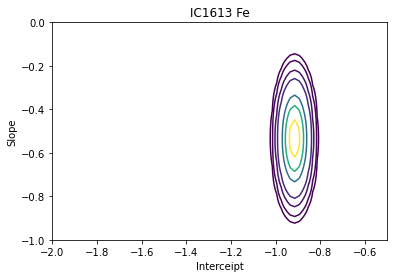

In [66]:
L = np.exp(post_array/2)
Lmax = np.max(L) 
lev = 1 - np.array([0.99, 0.98,0.95,0.90, 0.7, 0.5, 0.2])
plt.contour(L, extent=(-2,2, -1,1), levels=lev*Lmax)
 
plt.xlim([-2, -.5])
plt.ylim([-1, 0])

a = np.where(L >= 0.32 * Lmax)
h = np.where(L == Lmax)

bbest = B[h[1]][0]
abest = A[h[0]][0]
bmin, bmax = round(np.min(B[a[1]]),2), round(np.max(B[a[1]]),2)
amin, amax = round(np.min(A[a[0]]),2), round(np.max(A[a[0]]),2)

print(f"slope AH {abest:.2f} -{abest-amin:.2f} +{amax-abest:.2f}")
print(f"Interceipt BH {bbest:.2f} -{bbest-bmin:.2f} +{bmax-bbest:.2f}")
print(f"zH {zH_ic:.2f}")
plt.xlabel('Interceipt')
plt.ylabel('Slope')
plt.title("IC1613 Fe")


## Sextans A

Text(0.5, 1.0, 'Sextans A Fe')

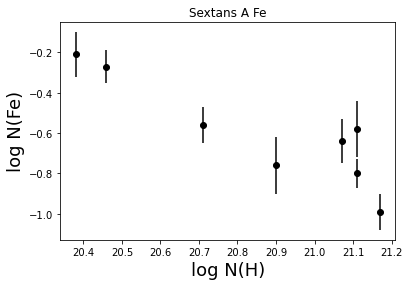

In [67]:
# data SexA- Fe
X = metalz['N(HI)'][10:,0]
Y = metalz['d(Fe)'][10:,0]
Yerr = metalz['d(Fe)'][10:, 1]
plt.errorbar(X,Y,yerr=Yerr, fmt='ko')
plt.xlabel("log N(H)", fontsize=18)
plt.ylabel("log N(Fe)", fontsize=18)
plt.title("Sextans A Fe")

In [68]:
zH_sa = calc_zh(X,Yerr)
print("SEXTANS A Fe zH =", f"{zH_sa:.2f}")

20.860863691641157
SEXTANS A Fe zH = 20.86


Text(0.5, 1.0, 'Sextans A Fe')

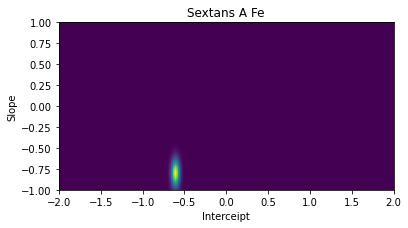

In [69]:
post_array = log_posterior_V_free(X,Y,Yerr, zH_sa)
plt.imshow(np.exp(post_array), extent=( -2,2,-1,1), origin='lower')
plt.xlabel('Interceipt')
plt.ylabel('Slope')
plt.title("Sextans A Fe")

slope AH -0.80 -0.20 +0.23
Interceipt BH -0.61 -0.06 +0.06
zH 20.86


Text(0.5, 1.0, 'Sextans A Fe')

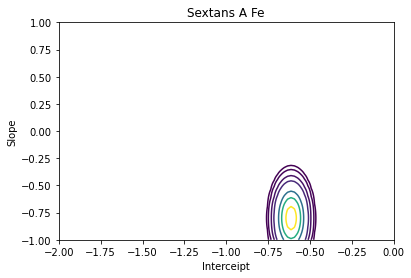

In [71]:
L = np.exp(post_array/2)
Lmax = np.max(L) 
lev = 1 - np.array([0.99, 0.98,0.95,0.90, 0.7, 0.5, 0.2])
plt.contour(L, extent=(-2,2, -1,1), levels=lev*Lmax)
 
plt.xlim([-2, 0])
plt.ylim([-1, 1])

a = np.where(L >=0.32*Lmax)
h = np.where(L == Lmax)

bbest = B[h[1]][0]
abest = A[h[0]][0]
bmin, bmax = round(np.min(B[a[1]]),2), round(np.max(B[a[1]]),2)
amin, amax = round(np.min(A[a[0]]),2), round(np.max(A[a[0]]),2)

print(f"slope AH {abest:.2f} -{abest-amin:.2f} +{amax-abest:.2f}")
print(f"Interceipt BH {bbest:.2f} -{bbest-bmin:.2f} +{bmax-bbest:.2f}")
print(f"zH {zH_sa:.2f}")

plt.xlabel('Interceipt')
plt.ylabel('Slope')
plt.title("Sextans A Fe")


# Old versions 

# COG results - A, B and fixed zH

## IC1613 Fe


Text(0, 0.5, 'd(Fe)')

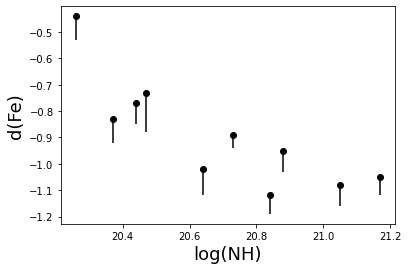

In [12]:
# data
X = ic1613['N(HI)'].T[0]
Y = ic1613['d(Fe)']

plt.errorbar(X,Y.T[0],yerr=[Y.T[1], Y.T[2]], fmt='ko')
plt.xlabel("log(NH)", fontsize=18)
plt.ylabel("d(Fe)", fontsize=18)

Text(0, 0.5, 'd(Fe)')

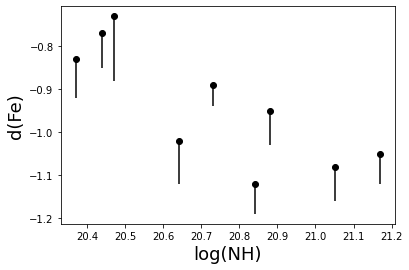

In [13]:
a = np.where(Y.T[0] < -.6)

plt.errorbar(X[a],Y.T[0][a],yerr=[Y.T[1][a], Y.T[2][a]], fmt='ko')
plt.xlabel("log(NH)", fontsize=18)
plt.ylabel("d(Fe)", fontsize=18)

In [81]:
# pdfs Read in
pdfs = glob.glob("COG/IC1613*FeIINPDF.txt")
T = get_pdfs(pdfs, icFe, np.size(X))
T.show_in_notebook()

IC1613-67684
IC1613-64066
IC1613-B7
IC1613-61331
IC1613-B11
IC1613-67559
IC1613-62024
IC1613-B2
IC1613-B3
IC1613-A13


idx,NH,PDF,dX
0,20.44,1.3141709571310196e-25 .. 4.01508622269209e-55,-5.310000000000001 .. 4.689999999999999
1,20.88,1.689097378278102e-36 .. 4.872949475008132e-17,-5.749999999999999 .. 4.250000000000001
2,20.73,3.1572607226744086e-60 .. 4.993126551808585e-21,-5.6000000000000005 .. 4.3999999999999995
3,20.84,2.715615628793362e-24 .. 1.771222685604561e-40,-5.71 .. 4.29
4,20.37,5.475348628516605e-14 .. 1.248864025978804e-34,-5.240000000000001 .. 4.759999999999999
5,20.47,1.0965521406016068e-27 .. 5.487525484643892e-31,-5.339999999999999 .. 4.660000000000001
6,21.05,8.313838642802497e-37 .. 4.673619052855172e-09,-5.920000000000001 .. 4.079999999999999
7,21.17,1.061296464098405e-38 .. 8.602102035905498e-12,-6.040000000000002 .. 3.959999999999998
8,20.64,6.163791523060635e-14 .. 1.349085936440292e-28,-5.510000000000001 .. 4.489999999999999
9,20.26,6.327951692738943e-24 .. 9.480882268400575e-24,-5.130000000000002 .. 4.869999999999998


In [82]:
# prior 
theta0 = (-0.71, 0.03)
# go over array
post_array = log_posterior(T, z0_Fe, theta0)

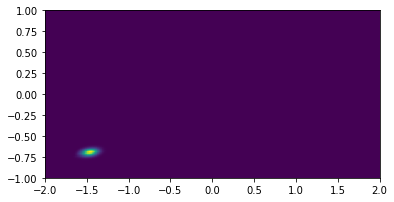

In [83]:
plt.imshow(np.exp(post_array), extent=(-2,2, -1,1), origin='lower')


(200, 200)
(array([24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36]), array([23, 24, 25, 26, 21, 22, 23, 24, 25, 26, 27, 28, 29, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 21, 

<ipython-input-84-206117397f73>:9: UserWarning: The following kwargs were not used by contour: 'lw'
  plt.contour(L, extent=(-2,2, -1,1), levels=[0.32*Lmax], lw=10 )


Text(0, 0.5, 'Slope')

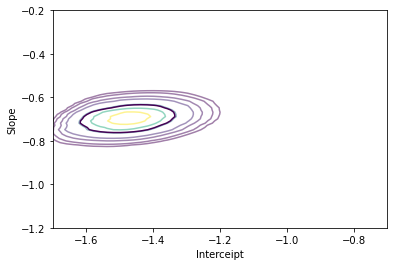

In [84]:
plt.xlim([-1.7, -0.7])
plt.ylim([-1.2, -0.2])

L = np.exp(post_array/2)
Lmax = np.max(L) 
print(np.shape(L))
lev = 1- np.array([0.99, 0.98,0.95,0.90, 0.7, 0.5, 0.2])
plt.contour(L, extent=(-2,2, -1,1), levels=lev*Lmax, alpha=0.5)
plt.contour(L, extent=(-2,2, -1,1), levels=[0.32*Lmax], lw=10 )

a = np.where(L >=0.32*Lmax)
print(a)
h = np.where(L == Lmax)
print(h)
bbest = B[h[1]][0]
abest = A[h[0]][0]
bmin, bmax = round(np.min(B[a[1]]),2), round(np.max(B[a[1]]),2)
amin, amax = round(np.min(A[a[0]]),2), round(np.max(A[a[0]]),2)
print("Interceipt" , bmin, bbest, bmax, bmin-bbest,bmax-bbest)
print("slope", amin,abest, amax, amin-abest, amax-abest)

plt.xlabel("Interceipt")
plt.ylabel("Slope")

[20.         20.04081633 20.08163265 20.12244898 20.16326531 20.20408163
 20.24489796 20.28571429 20.32653061 20.36734694 20.40816327 20.44897959
 20.48979592 20.53061224 20.57142857 20.6122449  20.65306122 20.69387755
 20.73469388 20.7755102  20.81632653 20.85714286 20.89795918 20.93877551
 20.97959184 21.02040816 21.06122449 21.10204082 21.14285714 21.18367347
 21.2244898  21.26530612 21.30612245 21.34693878 21.3877551  21.42857143
 21.46938776 21.51020408 21.55102041 21.59183673 21.63265306 21.67346939
 21.71428571 21.75510204 21.79591837 21.83673469 21.87755102 21.91836735
 21.95918367 22.        ]


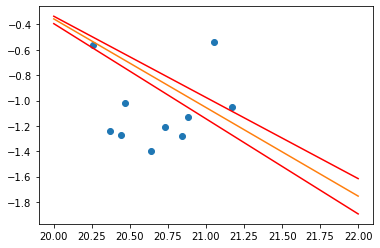

In [71]:
plt.plot(X, Y.T[0], 'o')
x = np.linspace(20,22)
print(x)
plt.plot(x, abest * (x - z0_Fe) + bbest)
plt.plot(x, amin * (x - z0_Fe) + bmin, c='r')
plt.plot(x, amax * (x - z0_Fe) + bmax, c='r')

#Fe dep(x) = log(N(x)) - log(N(H)) - log(X/H)
#ic1613_Fe = ic1613['log_N(FeII)_q0.5'] - ic1613['log_N(HI)'] - ic1613_FeH

## IC1613 S

Text(0, 0.5, 'd(S)')

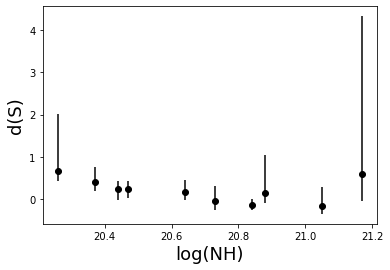

In [16]:
# data
X = ic1613['N(HI)'].T[0]
Y = ic1613['d(S)']

plt.errorbar(X,Y.T[0],yerr=[Y.T[1], Y.T[2]], fmt='ko')
plt.xlabel("log(NH)", fontsize=18)
plt.ylabel("d(S)", fontsize=18)

In [18]:
# pdfs Read in
pdfs = glob.glob("COG/IC1613*SII_NPDF.txt")
Ts = get_pdfs(pdfs, icS, np.size(X))
Ts.show_in_notebook()

IC1613-B7
IC1613-64066
IC1613-67684
IC1613-67559
IC1613-B11
IC1613-61331
IC1613-62024
IC1613-A13
IC1613-B3
IC1613-B2


idx,NH,PDF,dX
0,20.73,6.8504721680669775e-25 .. 4.349422538533841e-13,-5.130000000000001 .. 4.869999999999999
1,20.88,4.608760317479686e-43 .. 1.4040715997271984e-06,-5.279999999999999 .. 4.720000000000001
2,20.44,3.0917333055370824e-21 .. 1.5620154367110043e-76,-4.840000000000002 .. 5.159999999999998
3,20.47,1.4018924218030115e-41 .. 4.6831610821016694e-24,-4.869999999999999 .. 5.130000000000001
4,20.37,1.1058429004393287e-33 .. 1.1009002891541303e-21,-4.770000000000001 .. 5.229999999999999
5,20.84,2.568564904227869e-47 .. 4.693926391369891e-19,-5.24 .. 4.76
6,21.05,4.3830878251474865e-42 .. 1.02872247290123e-12,-5.450000000000001 .. 4.549999999999999
7,20.26,1.389144163568532e-29 .. 6.9185921105903865e-15,-4.660000000000002 .. 5.339999999999998
8,20.64,9.522548836337771e-35 .. 7.886688069410642e-10,-5.040000000000001 .. 4.959999999999999
9,21.17,1.2676002899556857e-70 .. 0.000721650798506526,-5.570000000000002 .. 4.429999999999998


In [19]:
#prior 
theta0 = (-0.64, 0.06)
#go over array
post_array = log_posterior(Ts, z0_S, theta0)

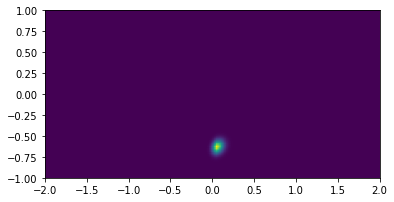

In [20]:
plt.imshow(np.exp(post_array), extent=( -2,2,-1,1), origin='lower')


Text(0, 0.5, 'Slope')

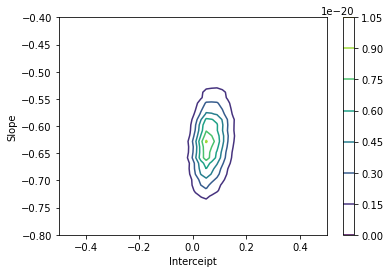

In [21]:
plt.contour(np.exp(post_array), extent=(-2,2, -1,1))
plt.colorbar()

plt.xlim([-0.5, 0.5])
plt.ylim([-0.8, -0.4])
plt.xlabel("Interceipt")
plt.ylabel("Slope")



(array([25, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29,
       29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31,
       31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 43,
       43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45,
       45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 48]), array([102, 101, 102, 103, 100, 101, 102, 103, 104, 100, 101, 102, 103,
       104, 105,  99, 100, 101, 102, 103, 104, 105,  99, 100, 101, 102,
       103, 104, 105, 106,  99, 100, 101, 102, 103, 104, 105, 106,  99,
       100, 101, 102, 103, 104, 105, 10

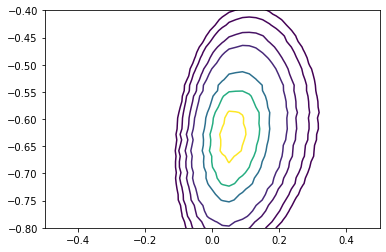

In [24]:
L = np.exp(post_array/2)
Lmax = np.max(L) 
lev = 1- np.array([0.99, 0.98,0.95,0.90, 0.7, 0.5, 0.2])
plt.contour(L, extent=(-2,2, -1,1), levels=lev*Lmax)
 
plt.xlim([-0.5, 0.5])
plt.ylim([-0.8, -0.4])

a = np.where(L >=0.32*Lmax)
print(a)
print(np.shape(L))
h = np.where(L == Lmax)
print(h)
bbest = B[h[1]][0]
abest = A[h[0]][0]
bmin, bmax = round(np.min(B[a[1]]),2), round(np.max(B[a[1]]),2)
amin, amax = round(np.min(A[a[0]]),2), round(np.max(A[a[0]]),2)
print("Interceipt" , bmin, bbest, bmax, bmin-bbest,bmax-bbest)
print("slope", amin,abest, amax, amin-abest, amax-abest)

# # bdo, bup = round(-bmin+bbest,2), round(bmax-bbest,2)
# # ndo, nup = round(-nmin+nbest,2), round(nmax-nbest,2)

# Sextans A Fe

Text(0, 0.5, 'd(Fe)')

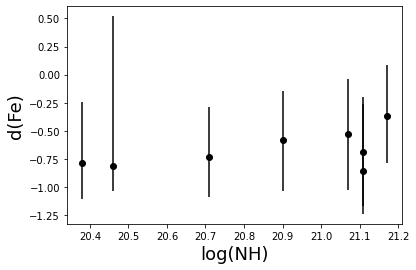

In [30]:
#data
X = sexA['N(HI)'].T[0]
Y = sexA['d(Fe)']

plt.errorbar(X,Y.T[0],yerr=[Y.T[1], Y.T[2]], fmt='ko')
plt.xlabel("log(NH)", fontsize=18)
plt.ylabel("d(Fe)", fontsize=18)

In [31]:
# pdfs Read in
pdfs = glob.glob("COG/SEXTANS-A*FeII_NPDF.txt")
Tf = get_pdfs(pdfs, saFe, np.size(X))
Tf.show_in_notebook()

SEXTANS-A-s3
SEXTANS-A-SA3
SEXTANS-A-OB523
SEXTANS-A-OB521
SEXTANS-A-SA2
SEXTANS-A-OB321
SEXTANS-A-OB326
SEXTANS-A-SA1


idx,NH,PDF,dX
0,20.9,2.187671163537322e-09 .. 1.751649411114524e-26,-5.449999999999998 .. 4.550000000000002
1,20.38,6.618133142500613e-14 .. 2.3562700159930952e-37,-4.929999999999999 .. 5.070000000000001
2,21.11,7.262927242026466e-21 .. 7.953019847201082e-19,-5.659999999999999 .. 4.340000000000001
3,21.17,6.775121691909074e-12 .. 2.632951840504225e-20,-5.7200000000000015 .. 4.2799999999999985
4,21.07,1.9492684648497476e-12 .. 6.753849009311542e-21,-5.62 .. 4.38
5,20.46,3.696869773206675e-11 .. 1.1795554141324396e-15,-5.010000000000001 .. 4.989999999999999
6,20.71,7.97376058134465e-15 .. 7.823813569469922e-30,-5.260000000000001 .. 4.739999999999999
7,21.11,5.4098372558202426e-14 .. 1.561659804792054e-25,-5.659999999999999 .. 4.340000000000001


In [32]:
# prior 
theta0 = (-0.71, 0.03)
# go over array
post_array = log_posterior(Tf, z0_Fe, theta0)

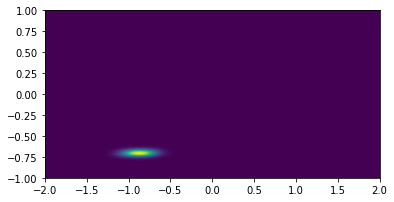

In [33]:
plt.imshow(np.exp(post_array), extent=(-2,2, -1,1), origin='lower')


(array([23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 3

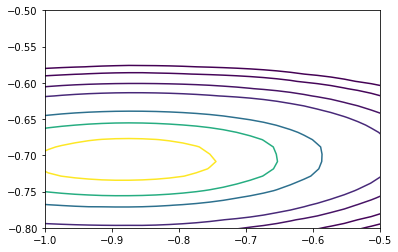

In [34]:
L = np.exp(post_array/2)
Lmax = np.max(L) 
lev = 1- np.array([0.99, 0.98,0.95,0.90, 0.7, 0.5, 0.2])
plt.contour(L, extent=(-2,2, -1,1), levels=lev*Lmax)
 
plt.xlim([-1, -0.5])
plt.ylim([-0.8, -0.5])

a = np.where(L >=0.32*Lmax)
print(a)
h = np.where(L == Lmax)
print(h)
bbest = B[h[1]][0]
abest = A[h[0]][0]
bmin, bmax = round(np.min(B[a[1]]),2), round(np.max(B[a[1]]),2)
amin, amax = round(np.min(A[a[0]]),2), round(np.max(A[a[0]]),2)
print("Interceipt" , bmin, bbest, bmax, bmin-bbest,bmax-bbest)
print("slope", amin,abest, amax, amin-abest, amax-abest)

# bdo, bup = round(-bmin+bbest,2), round(bmax-bbest,2)
# ndo, nup = round(-nmin+nbest,2), round(nmax-nbest,2)

# Sextans A S

Text(0, 0.5, 'd(S)')

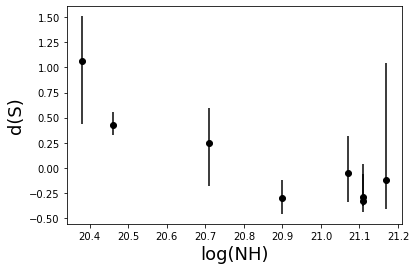

In [35]:
#data
X = sexA['N(HI)'].T[0]
Y = sexA['d(S)']

plt.errorbar(X,Y.T[0],yerr=[Y.T[1], Y.T[2]], fmt='ko')
plt.xlabel("log(NH)", fontsize=18)
plt.ylabel("d(S)", fontsize=18)

In [37]:
# pdfs Read in
pdfs = glob.glob("COG/SEXTANS-A*SII_NPDF.txt")
Ts = get_pdfs(pdfs, saS, np.size(X))
Ts.show_in_notebook()

SEXTANS-A-SA1
SEXTANS-A-OB523
SEXTANS-A-OB521
SEXTANS-A-SA2
SEXTANS-A-OB321
SEXTANS-A-OB326
SEXTANS-A-SA3
SEXTANS-A-s3


idx,NH,PDF,dX
0,21.11,3.911242949550202e-17 .. 1.265693447926594e-29,-5.1 .. 4.9
1,21.11,6.14410627247464e-30 .. 2.9404912579320184e-19,-5.1 .. 4.9
2,21.17,7.782160436368426e-18 .. 5.858973905883008e-15,-5.160000000000002 .. 4.839999999999998
3,21.07,1.6152332198682526e-22 .. 5.8178037865030146e-12,-5.0600000000000005 .. 4.9399999999999995
4,20.46,1.2568298163484644e-15 .. 1.788972717135205e-16,-4.450000000000001 .. 5.549999999999999
5,20.71,7.868317853671014e-11 .. 5.408039310264545e-36,-4.700000000000001 .. 5.299999999999999
6,20.38,2.59596536467576e-14 .. 1.4333850827378105e-22,-4.369999999999999 .. 5.630000000000001
7,20.9,4.1105093131730845e-08 .. 4.228915455754839e-38,-4.889999999999999 .. 5.110000000000001


In [39]:
#prior 
theta0 = (-0.71, 0.03)
#go over array
post_array=log_posterior(Ts, z0_S, theta0)

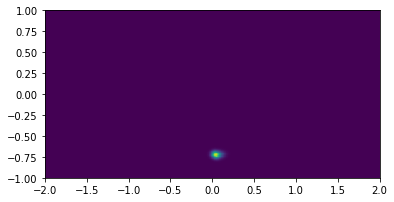

In [40]:
plt.imshow(np.exp(post_array), extent=(-2,2, -1,1), origin='lower')


(array([21, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24,
       25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30,
       31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33]), array([102, 101, 102, 103,  99, 100, 101, 102, 103, 104,  99, 100, 101,
       102, 103, 104, 105,  99, 100, 101, 102, 103, 104, 105, 106,  98,
        99, 100, 101, 102, 103, 104, 105, 106,  98,  99, 100, 101, 102,
       103, 104, 105, 106,  98,  99, 100, 101, 102, 103, 104, 105, 106,
        99, 100, 101, 102, 103, 104, 105, 106,  99, 100, 101, 102, 103,
       104, 105, 106,  99, 100, 101, 102, 103, 104, 105, 100, 101, 102,
       103, 104, 100, 101, 102]))
(array([28]), array([101]))
Interceipt -0.03 0.03015075376884413 0.13 -0.06015075376884413 0.09984924623115587
slope -0.79 -0.7185929648241206 -0.67 -0.071407035175

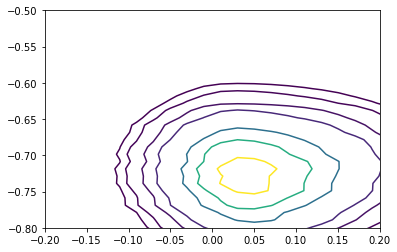

In [41]:
L = np.exp(post_array/2)
Lmax = np.max(L) 
lev = 1- np.array([0.99, 0.98,0.95,0.90, 0.7, 0.5, 0.2])
plt.contour(L, extent=(-2,2, -1,1), levels=lev*Lmax)
 
plt.xlim([-.2, 0.2])
plt.ylim([-0.8, -0.5])

a = np.where(L >=0.32*Lmax)
print(a)
h = np.where(L == Lmax)
print(h)
bbest = B[h[1]][0]
abest = A[h[0]][0]
bmin, bmax = round(np.min(B[a[1]]),2), round(np.max(B[a[1]]),2)
amin, amax = round(np.min(A[a[0]]),2), round(np.max(A[a[0]]),2)
print("Interceipt" , bmin, bbest, bmax, bmin-bbest,bmax-bbest)
print("slope", amin,abest, amax, amin-abest, amax-abest)

# bdo, bup = round(-bmin+bbest,2), round(bmax-bbest,2)
# ndo, nup = round(-nmin+nbest,2), round(nmax-nbest,2)

# Profile Fit - only for Fe

/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'IC1613 a = -0.56  b = -1.23')

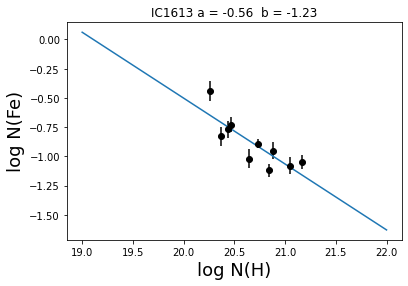

In [17]:
# linear regression
x = np.linspace(19,22) - z0_Fe

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X-z0_Fe,Y)

plt.errorbar(X,Y,yerr=Yerr, fmt='ko')
plt.plot(x+z0_Fe, slope * (x ) + intercept)
plt.xlabel("log N(H)", fontsize=18)
plt.ylabel("log N(Fe)", fontsize=18)
plt.title(f"IC1613 a = {slope:.2f}  b = {intercept:.2f}")

## with fixed a

Text(0.5, 1.0, 'IC1613 Fe')

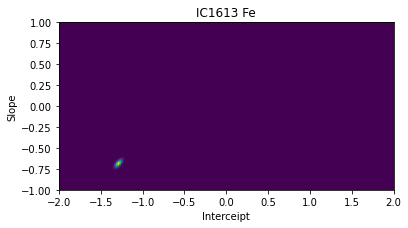

In [18]:
# prior 
theta0 = (-0.71, 0.03)
# go over array
post_array = log_posterior_V(X,Y, Yerr, z0_Fe, theta0)
plt.imshow(np.exp(post_array), extent=( -2,2,-1,1), origin='lower')
plt.xlabel('Interceipt')
plt.ylabel('Slope')
plt.title("IC1613 Fe")

Interceipt -1.34 -1.2964824120603016 -1.26 -0.04351758793969851 0.03648241206030156
slope -0.74 -0.6884422110552764 -0.63 -0.051557788944723626 0.05844221105527636


Text(0.5, 1.0, 'IC1613 Fe')

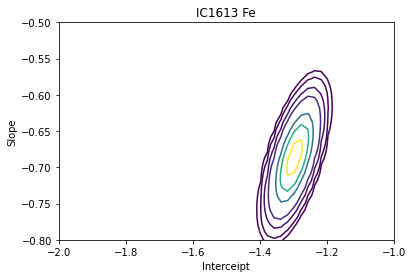

In [19]:
L = np.exp(post_array/2)
Lmax = np.max(L) 
lev = 1- np.array([0.99, 0.98,0.95,0.90, 0.7, 0.5, 0.2])
plt.contour(L, extent=(-2,2, -1,1), levels=lev*Lmax)
 
plt.xlim([-2, -1])
plt.ylim([-0.8, -0.5])

a = np.where(L >=0.32*Lmax)
h = np.where(L == Lmax)

bbest = B[h[1]][0]
abest = A[h[0]][0]
bmin, bmax = round(np.min(B[a[1]]),2), round(np.max(B[a[1]]),2)
amin, amax = round(np.min(A[a[0]]),2), round(np.max(A[a[0]]),2)
print("Interceipt" , bmin, bbest, bmax, bmin-bbest,bmax-bbest)
print("slope", amin,abest, amax, amin-abest, amax-abest)
plt.xlabel('Interceipt')
plt.ylabel('Slope')
plt.title("IC1613 Fe")

Text(0, 0.5, 'log N(Fe)')

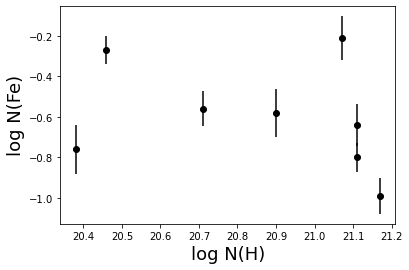

In [20]:
# Sextans A

X = new_voigt_fe['N(HI)'].T[0][10:]
Y = new_voigt_fe['dFe'][10:]
Yerr = new_voigt_fe['sd'][10:]
plt.errorbar(X,Y,yerr=Yerr, fmt='ko')
plt.xlabel("log N(H)", fontsize=18)
plt.ylabel("log N(Fe)", fontsize=18)

Text(0.5, 1.0, 'Sextans-A a = -0.23  b = -0.70')

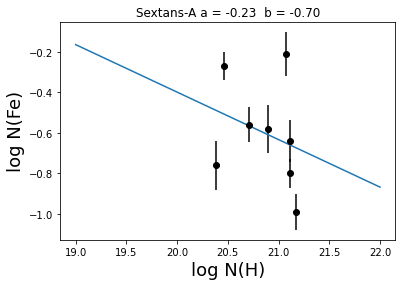

In [21]:
# linear regression
x = np.linspace(19,22) - z0_Fe

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X-z0_Fe,Y)

plt.errorbar(X,Y,yerr=Yerr, fmt='ko')
plt.plot(x+z0_Fe, slope * (x ) + intercept)
plt.xlabel("log N(H)", fontsize=18)
plt.ylabel("log N(Fe)", fontsize=18)
plt.title(f"Sextans-A a = {slope:.2f}  b = {intercept:.2f}")

Text(0.5, 1.0, 'Sextans A Fe')

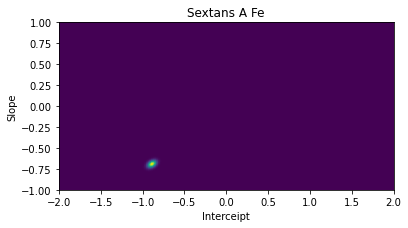

In [22]:
# prior 
theta0 = (-0.71, 0.03)
# go over array
post_array = log_posterior_V(X,Y,Yerr, z0_Fe, theta0)
plt.imshow(np.exp(post_array), extent=( -2,2,-1,1), origin='lower')
plt.xlabel('Interceipt')
plt.ylabel('Slope')
plt.title("Sextans A Fe")

Interceipt -0.95 -0.8944723618090451 -0.83 -0.05552763819095485 0.06447236180904514
slope -0.75 -0.6984924623115578 -0.64 -0.051507537688442184 0.0584924623115578


Text(0.5, 1.0, 'Sextans A Fe')

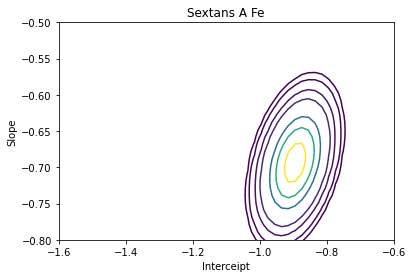

In [23]:
L = np.exp(post_array/2)
Lmax = np.max(L) 
lev = 1- np.array([0.99, 0.98,0.95,0.90, 0.7, 0.5, 0.2])
plt.contour(L, extent=(-2,2, -1,1), levels=lev*Lmax)
 
plt.xlim([-1.6, -.6])
plt.ylim([-0.8, -0.5])

a = np.where(L >=0.32*Lmax)
h = np.where(L == Lmax)

bbest = B[h[1]][0]
abest = A[h[0]][0]
bmin, bmax = round(np.min(B[a[1]]),2), round(np.max(B[a[1]]),2)
amin, amax = round(np.min(A[a[0]]),2), round(np.max(A[a[0]]),2)
print("Interceipt" , bmin, bbest, bmax, bmin-bbest,bmax-bbest)
print("slope", amin,abest, amax, amin-abest, amax-abest)
plt.xlabel('Interceipt')
plt.ylabel('Slope')
plt.title("Sextans A Fe")

## no constraints on A